# Automatically generating beetlemasks with SAM

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

## Set-up

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("./2018-NEON-beetles-processing/segmentation") 
from predict_masks import *


from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [2]:
def is_mask_closer_to_white(image, mask):
    # Calculate the average color of the masked area
    masked_area = image[mask]
    average_color = np.mean(masked_area, axis=0)
    # Calculate the Euclidean distance to white and black
    dist_to_white = np.linalg.norm(average_color - np.array([255, 255, 255]))
    dist_to_black = np.linalg.norm(average_color - np.array([0, 0, 0]))
    # Check if the masked area is closer to white than black
    return dist_to_white < dist_to_black

def is_mask_black(image, mask, threshold=10):
    """
    Checks if the masked area is black or very close to black.
    
    """
    # Calculate the average color of the masked area
    masked_area = image[mask]
    average_color = np.mean(masked_area, axis=0)
    
    # Check if the average color is below the threshold for all channels
    return np.all(average_color < threshold)

def crop_to_bb(image):
    # Get coordinates of the bounding box
    coords = np.argwhere(np.any(image != 0, axis=-1))
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    return image[x0:x1, y0:y1]

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
def show_anns_beetle(image, anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    color_mask = np.concatenate([np.random.random(3), [0.35]])
    for ann in sorted_anns:
        m = ann['segmentation']
        
        res = np.asarray(image) * np.repeat(m[:, :, None], 3, axis=2)

        # Skip background regions
        if is_mask_closer_to_white(res, m):
            continue
        img[m] = color_mask
    ax.imshow(img)

In [5]:
def show_anns_elythra(image, anns):
    max_area = 0
    best_res = None  
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    color_mask = np.concatenate([np.random.random(3), [0.35]])

    for ann in sorted_anns:        
        mask = ann['segmentation']
        res = np.asarray(image) * np.repeat(mask[:, :, None], 3, axis=2)

        # Check if the masked region is closer to white than to black, we filter the background regions
        if is_mask_closer_to_white(image, mask) or is_mask_black(image, mask):
            continue

        img[mask] = color_mask
        break
    ax.imshow(img)
    return crop_to_bb(res)
    

In [6]:
def show_mask_beetle(image, anns):
    combined_mask = np.zeros_like(image, dtype=np.uint8)

    for i, ann in enumerate(anns):
        mask = ann['segmentation']
        res = np.asarray(image) * np.repeat(mask[:, :, None], 3, axis=2)

        # Skip background regions
        if is_mask_closer_to_white(image, mask):
            continue

        # Combine the current mask with the combined mask using np.maximum
        combined_mask = np.maximum(combined_mask, res)

    # Crop the combined mask to its bounding box
    combined_mask_cropped = crop_to_bb(combined_mask)

    # Convert to BGR for saving
    combined_mask_bgr = cv2.cvtColor(combined_mask_cropped, cv2.COLOR_RGB2BGR)


    plt.figure(figsize=(20,20))
    plt.imshow(combined_mask_cropped)
    plt.axis('off')
    plt.show() 

    return combined_mask_cropped
    

In [7]:
def show_mask_elythra(image, anns):
    max_area = 0
    best_res = None    

    for i, ann in enumerate(anns):
        mask = ann['segmentation']
        res = np.asarray(image) * np.repeat(mask[:, :, None], 3, axis=2)

        # Check if the masked region is closer to white than to black, we filter the background regions
        if is_mask_closer_to_white(image, mask) or is_mask_black(image, mask):
            continue

        # Crop to bounding box
        res_cropped = crop_to_bb(res)

        # Calculate area of segmentation
        area = np.sum(mask)

        # Check if this is the largest segmentation found so far
        if area > max_area:
            max_area = area
            best_res = res_cropped

    # Save the largest non-background segmentation
    if best_res is not None:
        best_res_bgr = cv2.cvtColor(best_res, cv2.COLOR_RGB2BGR)

        # Now save the image with the correct color channels
        plt.figure(figsize=(20,20))
        plt.imshow(best_res)
        plt.axis('off')
        plt.show() 

## Example image

In [10]:
image = cv2.imread('../../shared/2018-NEON-beetles/separate_segmented_beetle_images/A00000001831/beetle_245.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

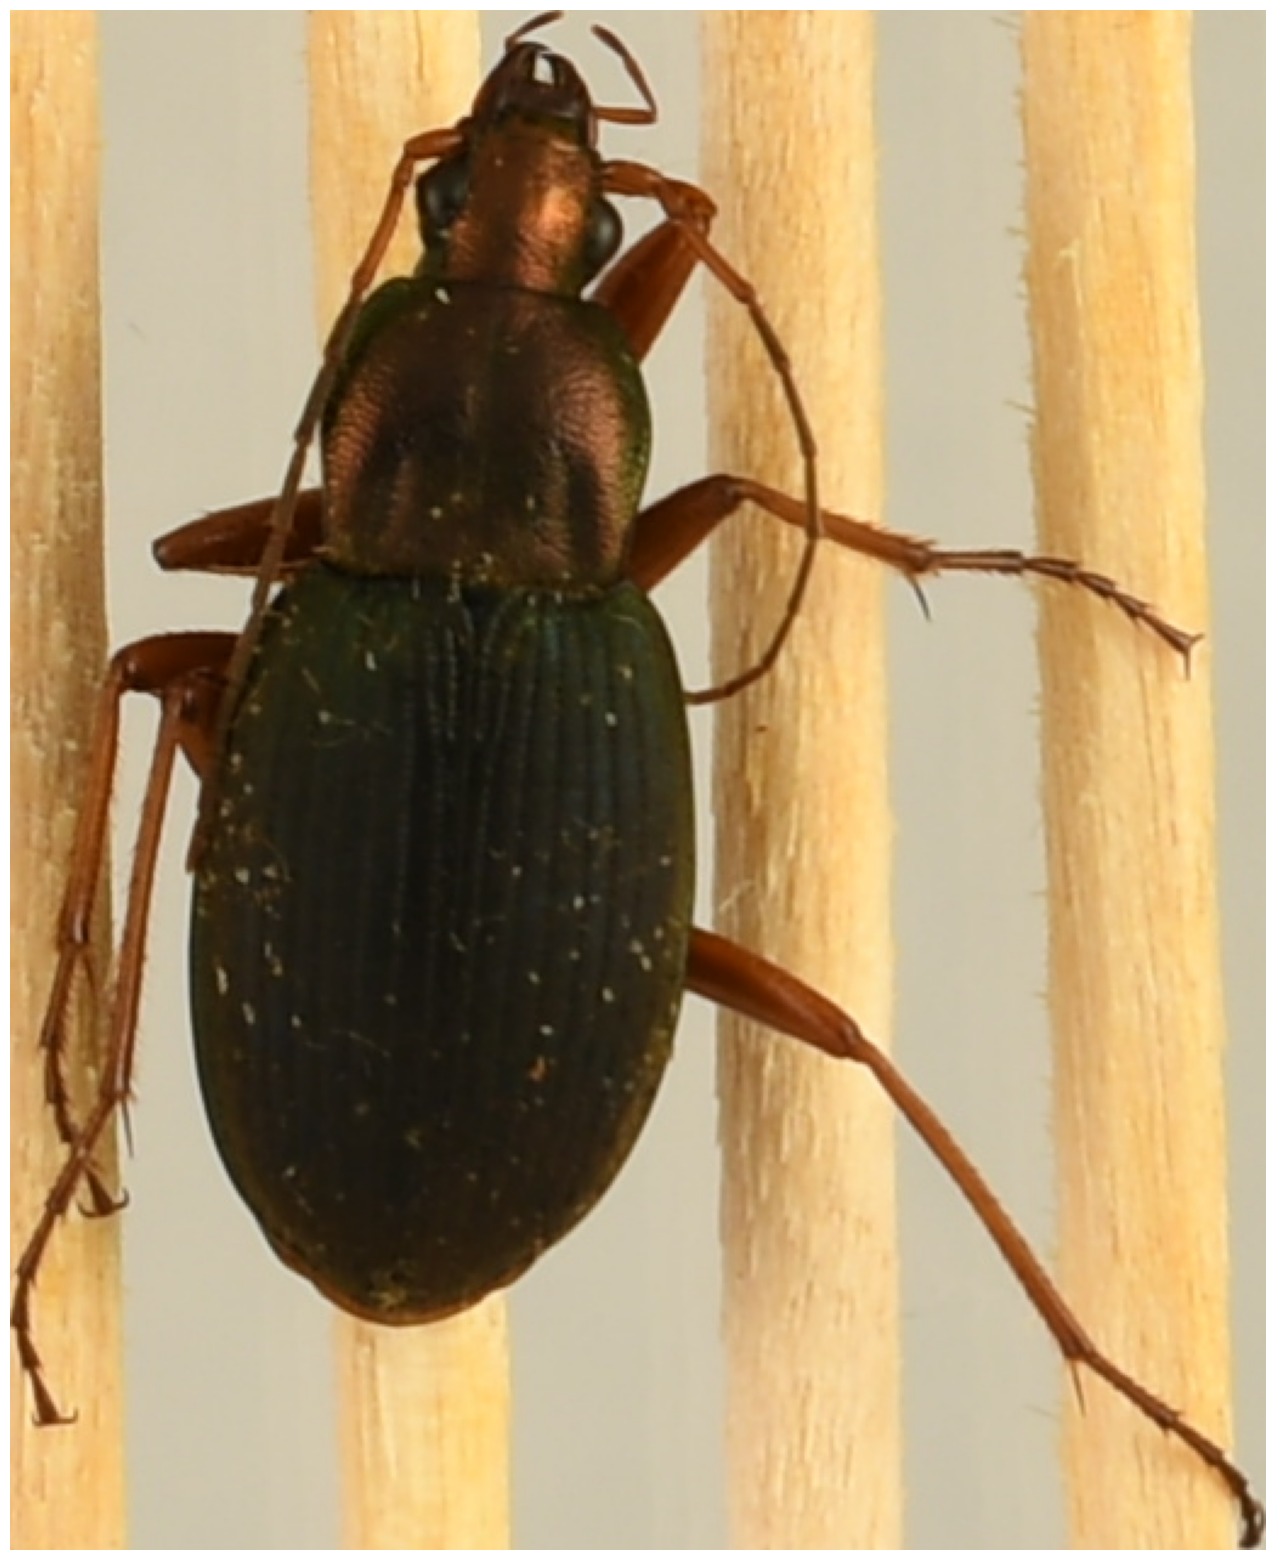

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

In [12]:
use_cuda = torch.cuda.is_available()
DEVICE   = torch.device("cuda:0" if use_cuda else "cpu")
print("Device: ", DEVICE)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Device:  cuda:0
__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: GRID A100X-40C
__CUDA Device Total Memory [GB]: 42.945347584


In [13]:
import sys
# load SAM model

segmentation_model = get_sam_model(DEVICE)

mask_generator = mask_generator = SamAutomaticMaskGenerator(
        model=segmentation_model,
        points_per_side=32,
        pred_iou_thresh=0.8,
        stability_score_thresh=0.85,
        crop_n_layers=2,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,  
    )

In [14]:
masks = mask_generator.generate(image)

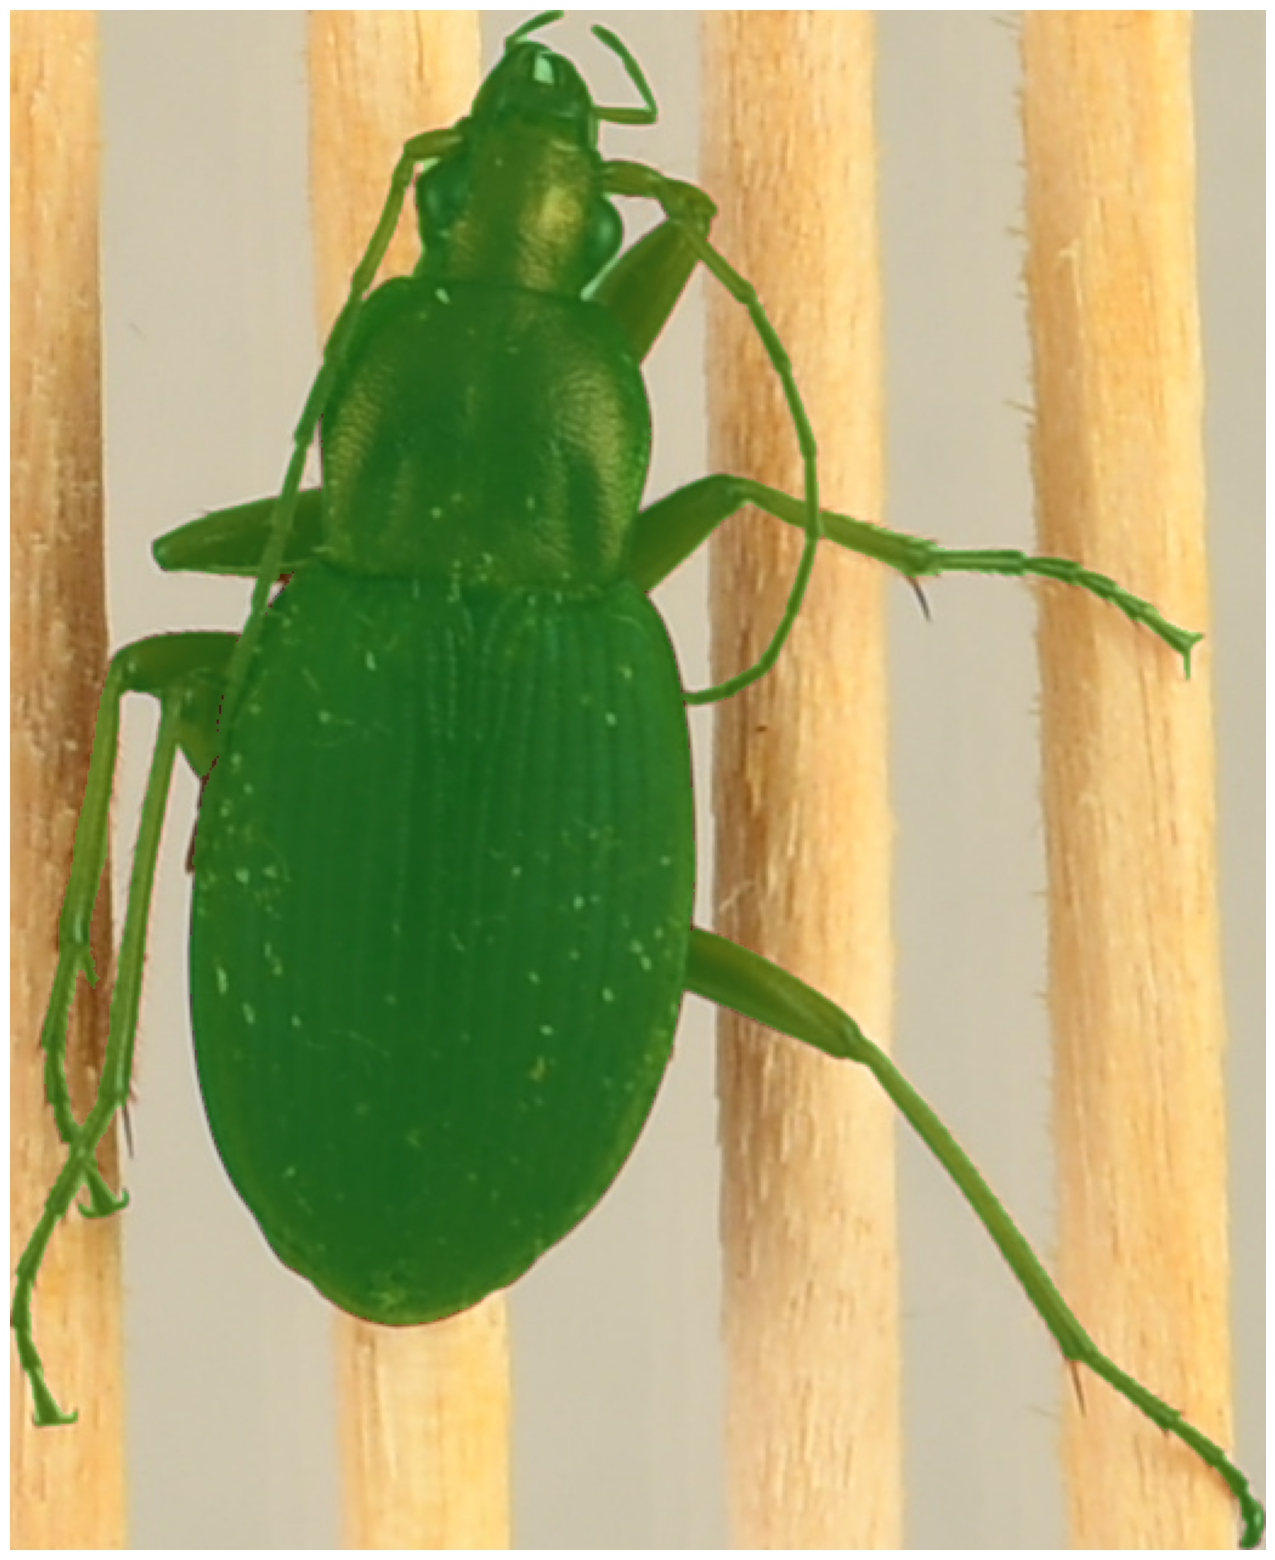

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(image)

show_anns_beetle(image, masks)
plt.axis('off')
plt.show() 

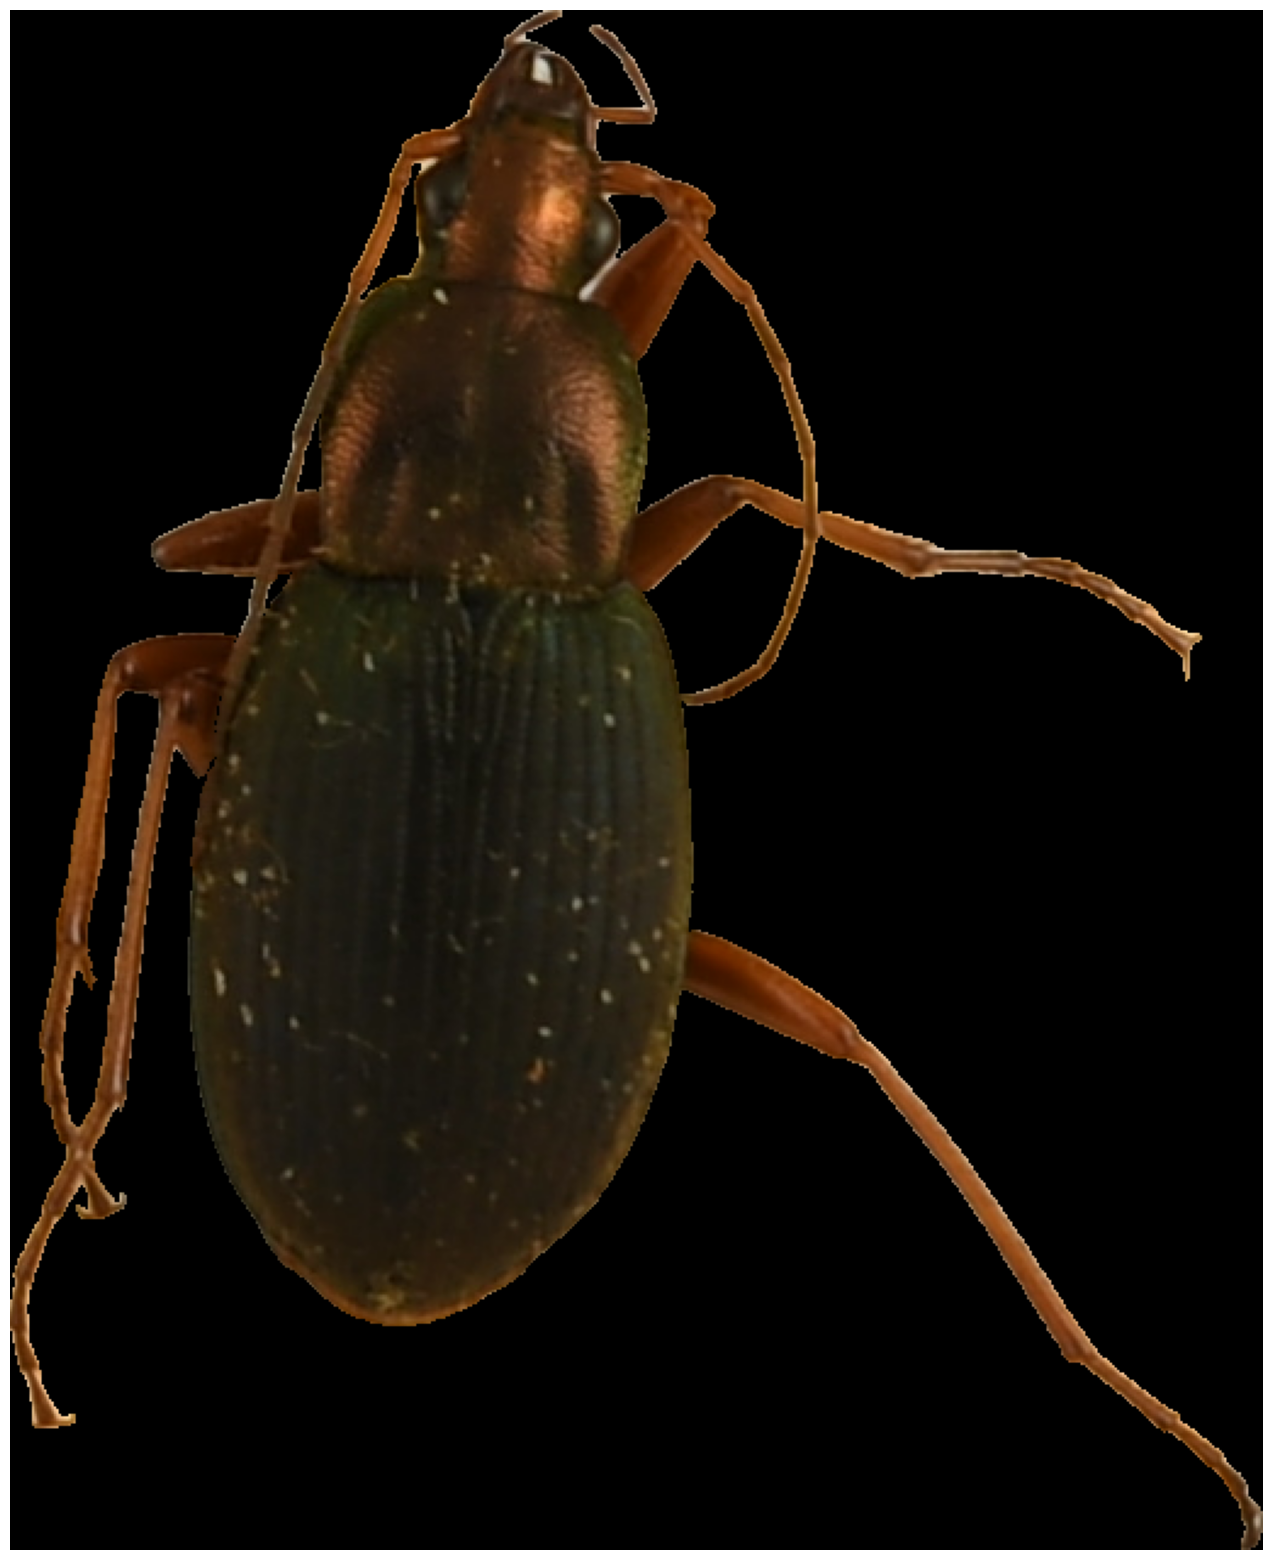

In [17]:
beetle_mask = show_mask_beetle(image, masks)

## Segment elythra

In [38]:
mask_generator_elyhtra = SamAutomaticMaskGenerator(model=segmentation_model, box_nms_thresh=0.5)

In [39]:
masks_elythra = mask_generator_elyhtra.generate(beetle_mask)

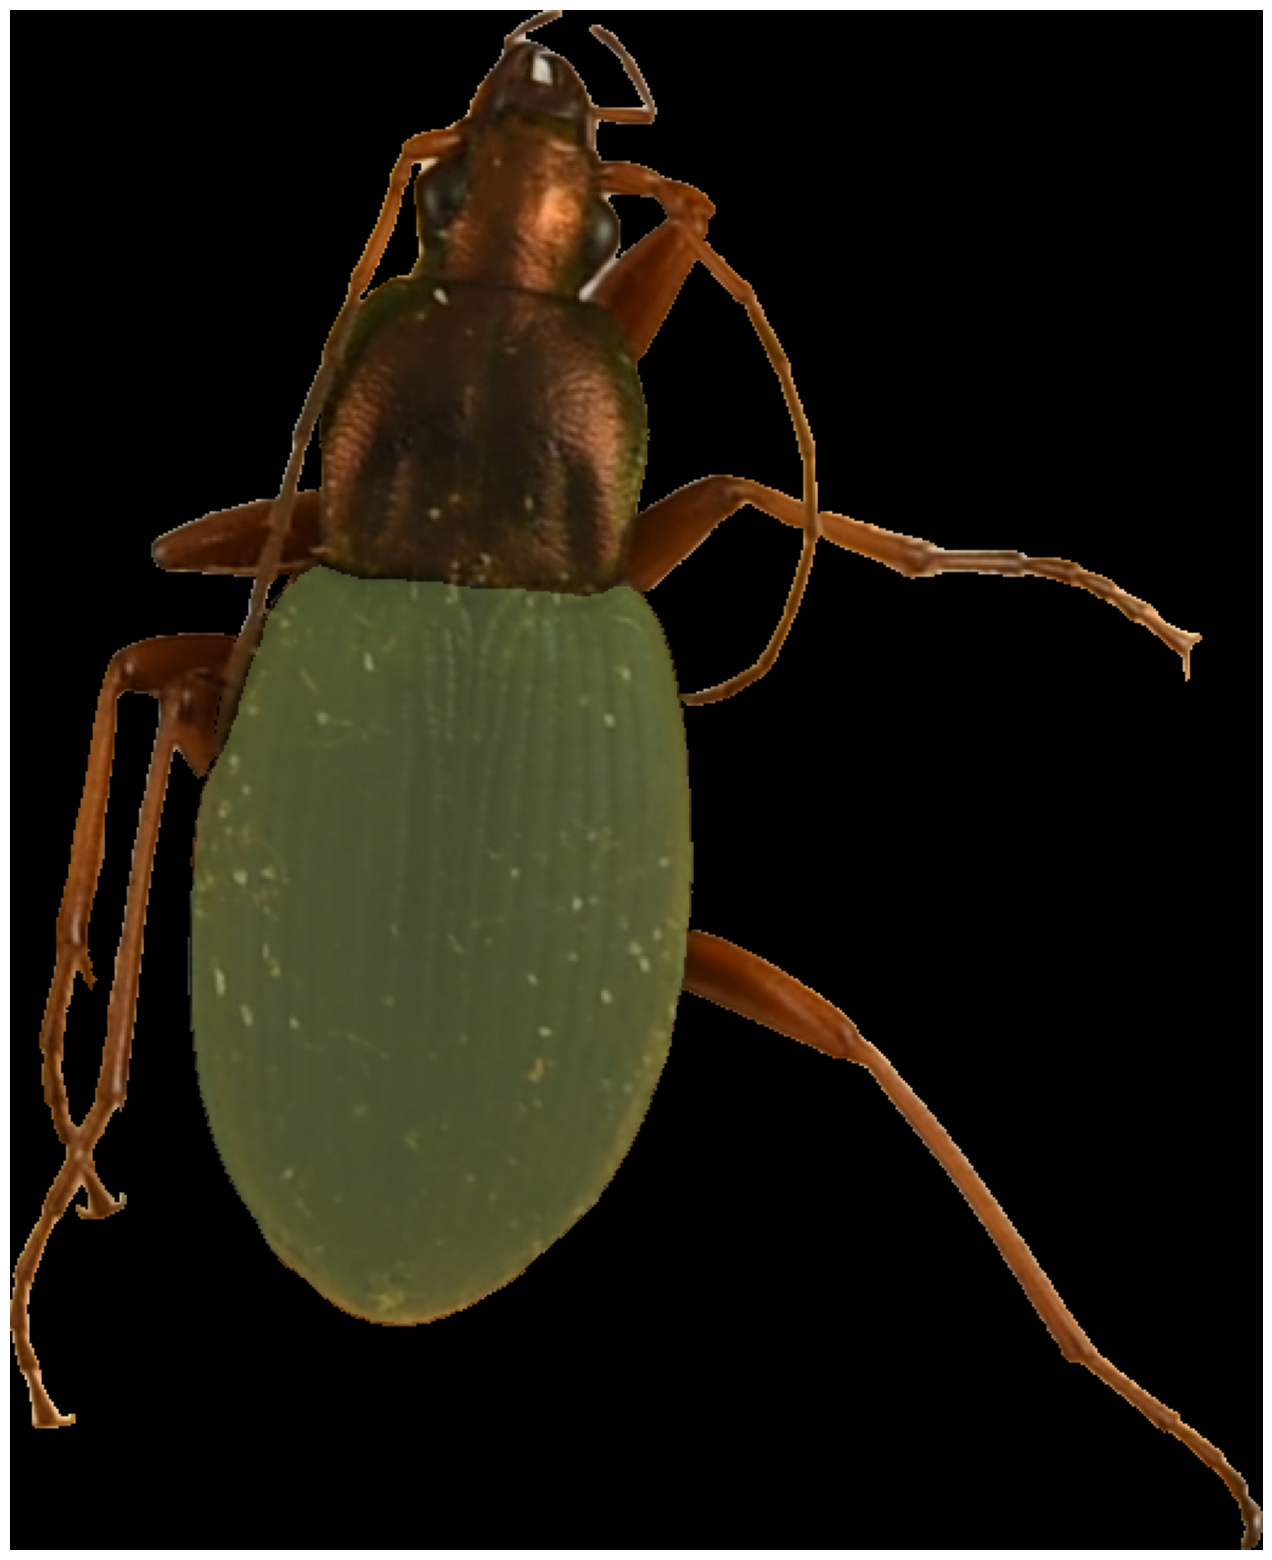

In [40]:
#highlight elythra on a beetle
plt.figure(figsize=(20,20))
plt.imshow(beetle_mask)

elythra_mask = show_anns_elythra(beetle_mask, masks_elythra)
plt.axis('off')
plt.show() 

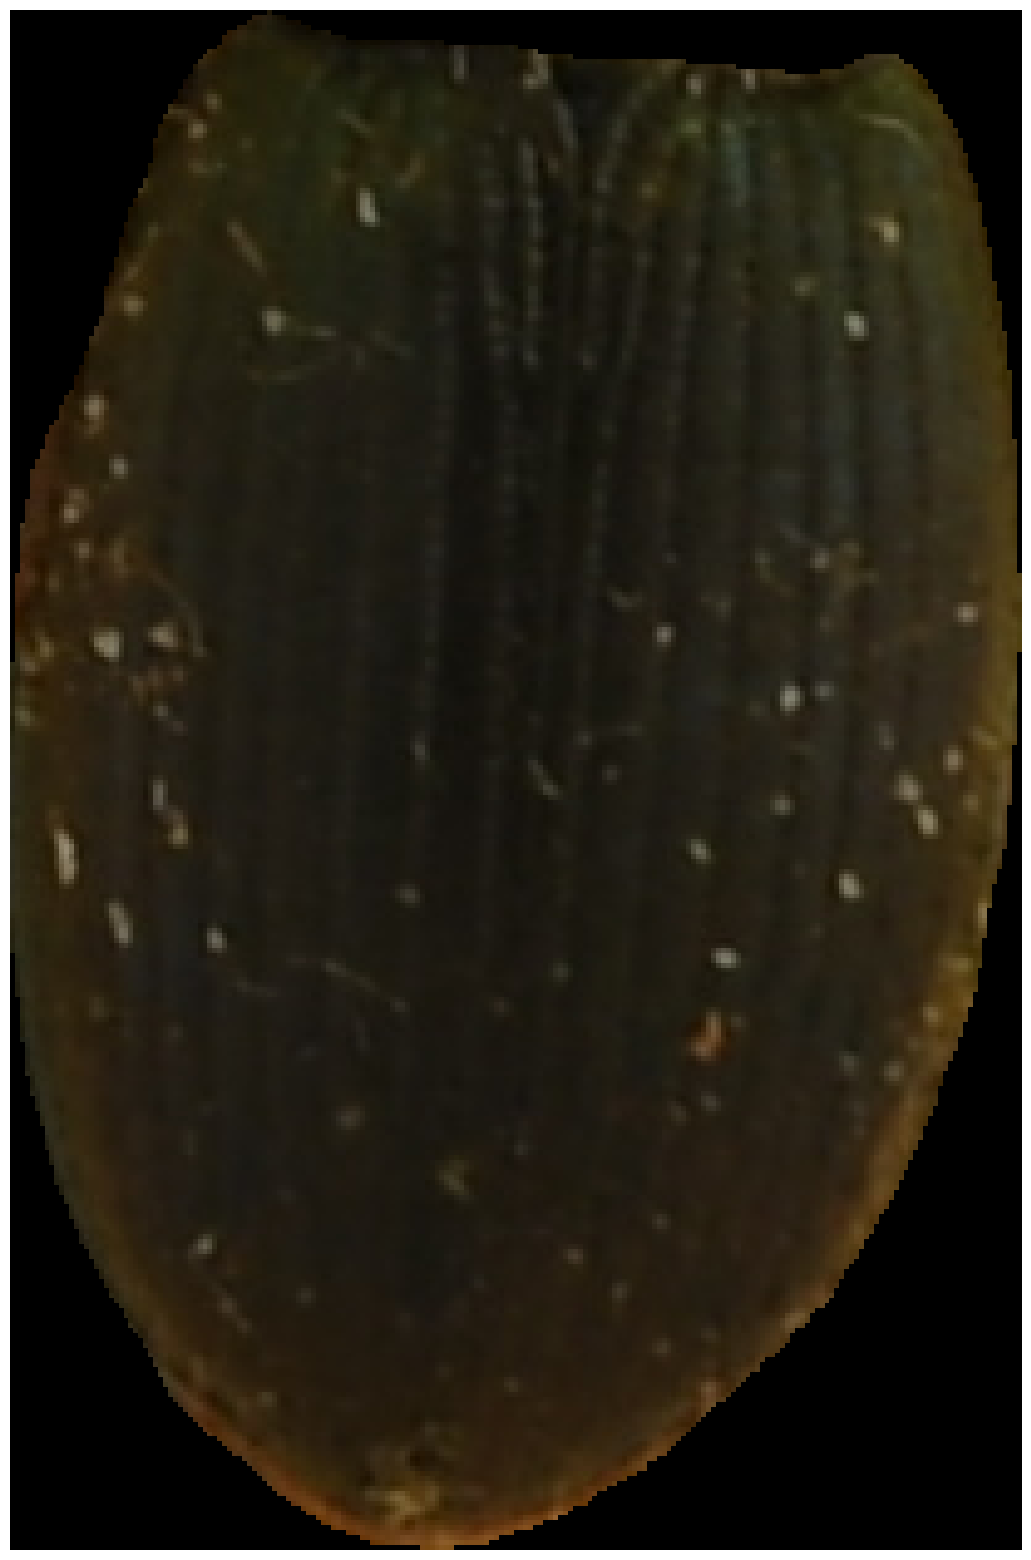

In [34]:

#show cropped elythra 
plt.figure(figsize=(20,20))
plt.imshow(elythra_mask)
plt.axis('off')
plt.show() 